In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
import cv2
from tqdm import tqdm
import numpy as np
import pandas as pd
import pickle
from sklearn.metrics import auc as compute_auc
from glob import glob
from PIL import Image
import torch
import torch.nn as nn
from torch_geometric.loader import DataLoader
from tqdm import tqdm
import faiss
from prettytable import PrettyTable
import matplotlib.pyplot as plt

import os
import sys
import inspect

currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0, parentdir) 

from dataloader.anaxnet import OcclusionDataset, DiseaseOcclusionDataset
from model.graph_transformer import CustomModel as GTModel
from model.anaxnet import CustomModel as AnaxNetModel
from model.nine_class_classifier import CustomModel as ResNet50
from model.ath import CustomModel as ATHModel
from common_metrics import compute_metrics

# Some Analysis

In [ ]:
nine_class_labels = [
    'lung opacity', 
    'pleural effusion', 
    'atelectasis', 
    'enlarged cardiac silhouette',
    'pulmonary edema/hazy opacity', 
    'pneumothorax', 
    'consolidation', 
    'fluid overload/heart failure', 
    'pneumonia']

anatomy_names = [
    'right lung',
    'right apical zone',
    'right upper lung zone',
    'right mid lung zone',
    'right lower lung zone',
    'right hilar structures',
    'right costophrenic angle',
    'left lung',
    'left apical zone',
    'left upper lung zone',
    'left mid lung zone',
    'left lower lung zone',
    'left hilar structures',
    'left costophrenic angle',
    'mediastinum',
    'upper mediastinum',
    'cardiac silhouette',
    'trachea']

In [ ]:
gpu0 = np.load('/scratch/arihanth.srikar/dump_imp_output/auc_analysis/lookup_dicts/gpu_0.npy')
gpu1 = np.load('/scratch/arihanth.srikar/dump_imp_output/auc_analysis/lookup_dicts/gpu_1.npy')
gpu2 = np.load('/scratch/arihanth.srikar/dump_imp_output/auc_analysis/lookup_dicts/gpu_2.npy')

In [ ]:
data = np.concatenate([gpu0, gpu1, gpu2], axis=0)
data.shape

In [ ]:
# find duplicate entries in data
unique, counts = np.unique(data, return_counts=True, axis=0)
print('unique:', unique.shape)

In [ ]:
topk = 10
df_gt = pd.read_csv(f'results/graph_transformer/best_config_abs_pos_with_edges/occluded/orig/9_classes_auc_no_global_feat_top_{topk}_cosine_.txt')

In [ ]:
df_consolidated = df_gt[['query_indices', 'target_indices']].drop_duplicates().reset_index(drop=True)
df_consolidated

In [ ]:
consider_disease = 'enlarged cardiac silhouette'
consider_anatomy = 'cardiac silhouette'
query_ids = df_gt[df_gt['label_name'] == consider_disease]['query_indices'].to_list()
len(query_ids)

In [ ]:
include_indices = [anatomy_names.index(anat) for anat in anatomy_names if anat not in ['right lung', 'left lung', 'mediastinum', 'upper mediastinum', 'trachea']]
include_indices

In [ ]:
best_labels = np.load('/scratch/arihanth.srikar/dump_imp_output/auc_analysis/labels.npy')
best_labels.shape

In [ ]:
t = PrettyTable(['Disease', 'Anatomy', 'Relative Importance'])
for consider_disease in tqdm(nine_class_labels):
    query_ids = df_gt[df_gt['label_name'] == consider_disease]['query_indices'].to_list()

    for consider_anatomy in [anatomy_names[i] for i in include_indices]:
        score = 0
        for q_id in query_ids:
            entry = df_consolidated[df_consolidated['query_indices'] == q_id]
            
            c_id = entry.index[0]
            data_entry = data[c_id]
            target_ids = eval(entry['target_indices'].to_list()[0])
            
            # print(q_id, target_ids, c_id)

            for i in range(0, data_entry.shape[0], 18):
                temp = list(zip(data_entry[i:i+18][include_indices], np.array(anatomy_names)[include_indices]))
                temp = sorted(temp, key=lambda x: x[0], reverse=False)
                # get index of consider_anatomy
                idx = [x[1] for x in temp].index(consider_anatomy)
                score += (idx+1)/len(include_indices)

        # print(f'The importance of {consider_anatomy} for {consider_disease} is {score/(len(query_ids)*topk):.3f}')
        t.add_row([consider_disease, consider_anatomy, f'{score/(len(query_ids)*topk):.3f}'])
    t.add_row(['', '', ''])
print(t)

# Utils

In [2]:
nine_class_labels = [
    'lung opacity', 
    'pleural effusion', 
    'atelectasis', 
    'enlarged cardiac silhouette',
    'pulmonary edema/hazy opacity', 
    'pneumothorax', 
    'consolidation', 
    'fluid overload/heart failure', 
    'pneumonia']

anatomy_names = [
    'right lung',
    'right apical zone',
    'right upper lung zone',
    'right mid lung zone',
    'right lower lung zone',
    'right hilar structures',
    'right costophrenic angle',
    'left lung',
    'left apical zone',
    'left upper lung zone',
    'left mid lung zone',
    'left lower lung zone',
    'left hilar structures',
    'left costophrenic angle',
    'mediastinum',
    'upper mediastinum',
    'cardiac silhouette',
    'trachea']

In [3]:
def calculate_metric(targets):
    mAP, mHR, mRR = [], [], []

    for _, target in enumerate(targets):
        if target.sum() == 0:
            mAP.append(0)
            mHR.append(0)
            mRR.append(0)
            continue

        pos = 0
        found_hit = False
        AP = []
        for i, t in enumerate(target):
            if t:
                pos += 1
                AP.append(pos/(i+1))
                if not found_hit: mRR.append(1/(i+1))
                found_hit = True
        mHR.append(int(found_hit))
        mAP.append(np.mean(AP) if len(AP) > 0 else 0)

    return mAP, mHR, mRR

In [4]:
def extract_metrics(all_emb, all_labels, top_k=10):    

    index = faiss.IndexFlatIP(all_emb.shape[1])
    all_emb = all_emb / np.linalg.norm(all_emb, axis=1, keepdims=True)
    index.add(all_emb)

    # targets contains the retrieved labels checked against ground truth labels
    # predictions contain the distances of the retrieved labels
    all_targets_for_metric = {lbl_name: [] for lbl_name in nine_class_labels}
    all_similarity_for_metric = {lbl_name: [] for lbl_name in nine_class_labels}
    all_query_ids = {lbl_name: [] for lbl_name in nine_class_labels}
    all_retrieved_ids = {lbl_name: [] for lbl_name in nine_class_labels}

    # perform retrieval and save the input required for the metrics
    for query_id, (emb, query_labels) in enumerate(tqdm(zip(all_emb, all_labels), total=len(all_emb))):
        
        # expand dimension
        emb = emb[np.newaxis, ...]
        query_labels = query_labels[np.newaxis, ...]
        
        # perform retrieval
        D, I = index.search(emb, top_k+1)

        # find the corresponding labels from the retrieved indices
        # ignore the first one as it the query itself
        labels = all_labels[I[:, 1:]]
        similarity = torch.tensor(D[:, 1:])

        # we only care about query labels that are present
        target = torch.tensor(labels == 1)

        # class wise metrics
        for i, label_name in enumerate(nine_class_labels):
            
            # works with batched retrieval as well
            consider_batches = query_labels[:, i] == 1
            if consider_batches.sum() == 0:
                continue
            # extract only the relevant batches
            temp_target = target[consider_batches]
            temp_similarity = similarity[consider_batches]

            # save necessary values
            all_targets_for_metric[label_name].append(temp_target[:, :, i])
            all_similarity_for_metric[label_name].append(temp_similarity)
            all_query_ids[label_name].append(query_id)
            all_retrieved_ids[label_name].append(I[consider_batches, 1:].squeeze())

    # convert to tensors
    all_targets_for_metric = {k: torch.cat(v) for k, v in all_targets_for_metric.items()}
    all_similarity_for_metric = {k: torch.cat(v) for k, v in all_similarity_for_metric.items()}
    all_query_ids = {k: torch.tensor(v) for k, v in all_query_ids.items()}

    df = pd.DataFrame(columns=['Disease', 'mAP', 'mHR', 'mRR', 'query_id', 'retrieved_ids'])

    for k_diseases, v_diseases in all_targets_for_metric.items():
        mAP, mHR, mRR = calculate_metric(v_diseases)
        df_temp = pd.DataFrame({'Disease': [k_diseases]*len(mAP), 'mAP': mAP, 'mHR': mHR, 'mRR': mRR, 'query_id': all_query_ids[k_diseases], 'retrieved_ids': all_retrieved_ids[k_diseases]})
        df = pd.concat([df, df_temp])

    return df

In [5]:
def cosine_similarity(a, b):
    a = a.reshape(-1) if len(a.shape) > 1 else a
    b = b.reshape(-1) if len(b.shape) > 1 else b
    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))

In [6]:
def denormalize_image(image):
    image = image.clone().permute(1, 2, 0).numpy()
    image -= np.min(image)
    image /= np.max(image)
    image = np.uint8(image * 255)
    return image

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

config = {
    'lr': 0.0001,
    'num_layers': 2,
    'graph_importance': 1.0,
    'dropout': 0.0,
    'fully_connected': True,
    'contrastive': False,
    'concat_global_feature': False,
    'image_featuriser': 'resnet',
    'multiscale': False,
    'is_global_feat': False,
    'cls': False,
    'matryoshka': False,
    'rel_pos': False,
    'abs_pos': True,
    'accept_edges': True,
    'residual_type': 2,
    'task': 'anaxnet',
    'run': 'anaxnet',
}
model_paths = sorted(glob(f'/home/ssd_scratch/users/arihanth.srikar/checkpoints/mimic-cxr/{config["run"]}/*.ckpt'))
model_path = [md_name for md_name in model_paths if 'auc' in md_name][-1]
anaxnet_model = AnaxNetModel.load_from_checkpoint(model_path, config=config)
anaxnet_model = anaxnet_model.eval()
anaxnet_model = anaxnet_model.to(device)

for p in anaxnet_model.parameters():
    p.requires_grad = False

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# image must be 256x256
config = {
    'lr': 0.0001,
    'num_classes': 9,
    'dropout': 0.0,
    'concat_global_feature': False,
    'is_global_feat': False,
    'hash_bits': 32,
    'task': 'ath',
    'run': 'ath',
}
model_paths = sorted(glob(f'/home/ssd_scratch/users/arihanth.srikar/checkpoints/mimic-cxr/{config["run"]}/*.ckpt'))
model_path = [md_name for md_name in model_paths if 'auc' in md_name][-1]
ath_model = ATHModel.load_from_checkpoint(model_path, config=config)
ath_model = ath_model.eval()
ath_model = ath_model.to(device)

for p in ath_model.parameters():
    p.requires_grad = False

from torchvision import transforms
# resize to 256x256
ath_transform = transforms.Compose([
    transforms.Resize((256, 256), antialias=True),
])

ATHNet: 32 bits, 9 classes


In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

config = {
    'lr': 0.0001,
    'num_classes': 9,
    'dropout': 0.0,
    'concat_global_feature': False,
    'image_featuriser': 'resnet',
    'multiscale': False,
    'is_global_feat': False,
    'prune': False,
    'task': 'resnet50',
    'run': 'resnet50_fc_new',
}
model_paths = sorted(glob(f'/home/ssd_scratch/users/arihanth.srikar/checkpoints/mimic-cxr/{config["run"]}/*.ckpt'))
model_path = [md_name for md_name in model_paths if 'auc' in md_name][-1]
resnet_model = ResNet50.load_from_checkpoint(model_path, config=config)
resnet_model = resnet_model.eval()
resnet_model = resnet_model.to(device)

for p in resnet_model.parameters():
    p.requires_grad = False

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

config = {
    'lr': 0.0001,
    'num_layers': 2,
    'graph_importance': 1.0,
    'dropout': 0.0,
    'fully_connected': True,
    'contrastive': False,
    'concat_global_feature': False,
    'image_featuriser': 'resnet',
    'multiscale': False,
    'is_global_feat': False,
    'cls': False,
    'matryoshka': False,
    'rel_pos': False,
    'abs_pos': True,
    'accept_edges': True,
    'residual_type': 2,
    'task': 'graph_transformer',
    'run': 'best_config_abs_pos_with_edges',
}
model_paths = sorted(glob(f'/home/ssd_scratch/users/arihanth.srikar/checkpoints/mimic-cxr/{config["run"]}/*.ckpt'))
model_path = [md_name for md_name in model_paths if 'auc' in md_name][-1]
best_model = GTModel.load_from_checkpoint(model_path, config=config)
best_model = best_model.eval()
best_model = best_model.to(device)

for p in best_model.parameters():
    p.requires_grad = False


Using global gated residue


In [11]:
def get_retrieval_info(
        df: pd.DataFrame, 
        quer_id: int, 
        retrieved_id: int,
        model: nn.Module, 
        anatomy_names: list=anatomy_names,):
    
    test_dataset = OcclusionDataset(df, split='test')
    
    # get query info for a model
    original_sample = test_dataset[quer_id]
    inp = (original_sample['node_feat']).unsqueeze(0).to(device)
    y = original_sample['y']
    y_9 = torch.sum(y, dim=0) > 0
    relevant_anatomies = [anatomy_names[i] for i, y_row in enumerate(y) if y_row.sum() > 0]
    relevant_diseases = [nine_class_labels[i] for i, y_row in enumerate(y_9) if y_row]

    lookup_dict = {'query': {'img': original_sample['global_feat'], 'mask': original_sample['masked_img'], 
                                'sub_anatomies': original_sample['node_feat'], 'sub_anatomy_masks': original_sample['sub_anatomy_masks']}}
    lookup_dict['query']['emb'] = model.retrieval_pass(inp).detach().cpu().squeeze()
    lookup_dict['query']['anatomies'] = relevant_anatomies
    lookup_dict['query']['diseases'] = relevant_diseases
    
    # get original info for a model
    original_sample = test_dataset[retrieved_id]
    inp = original_sample['node_feat'].unsqueeze(0).to(device)
    y = original_sample['y']
    y_9 = torch.sum(y, dim=0) > 0
    relevant_anatomies = [anatomy_names[i] for i, y_row in enumerate(y) if y_row.sum() > 0]
    relevant_diseases = [nine_class_labels[i] for i, y_row in enumerate(y_9) if y_row]

    lookup_dict['original'] = {'img': original_sample['global_feat'], 'mask': original_sample['masked_img'], 
                                'sub_anatomies': original_sample['node_feat'], 'sub_anatomy_masks': original_sample['sub_anatomy_masks']}
    lookup_dict['original']['emb'] = model.retrieval_pass(inp).detach().cpu().squeeze()
    lookup_dict['original']['anatomies'] = relevant_anatomies
    lookup_dict['original']['diseases'] = relevant_diseases

    # get occluded info for a model
    for anatomy in anatomy_names:
        # if anatomy == 'right lung' or anatomy == 'left lung':
        #     continue

        # initialise dataset with occluded anatomy
        occluded_dataset = OcclusionDataset(df, split='test', occlude_anatomy=[anatomy])
        occluded_sample = occluded_dataset[retrieved_id]
        inp = occluded_sample['node_feat'].unsqueeze(0).to(device)
        
        # save the occluded anatomy's features and mask
        lookup_dict[anatomy] = {'img': occluded_sample['global_feat'], 'mask': occluded_sample['masked_img'], 
                                'sub_anatomies': original_sample['node_feat'], 'sub_anatomy_masks': occluded_sample['sub_anatomy_masks']}
        lookup_dict[anatomy]['emb'] = model.retrieval_pass(inp).detach().cpu().squeeze()

    return lookup_dict

def get_retrieval_info_non_graph(
        df: pd.DataFrame, 
        quer_id: int, 
        retrieved_id: int,
        model: nn.Module, 
        anatomy_names: list=anatomy_names,
        transforms: transforms.Compose=None,):
    
    test_dataset = OcclusionDataset(df, split='test')
    
    # get query info for a model
    original_sample = test_dataset[quer_id]
    inp = (original_sample['global_feat'] if transforms is None else transforms(original_sample['global_feat'])).unsqueeze(0).to(device)
    y = original_sample['y']
    y_9 = torch.sum(y, dim=0) > 0
    relevant_anatomies = [anatomy_names[i] for i, y_row in enumerate(y) if y_row.sum() > 0]
    relevant_diseases = [nine_class_labels[i] for i, y_row in enumerate(y_9) if y_row]

    lookup_dict = {'query': {'img': original_sample['global_feat'], 'mask': original_sample['masked_img'], 
                                'sub_anatomies': original_sample['node_feat'], 'sub_anatomy_masks': original_sample['sub_anatomy_masks']}}
    lookup_dict['query']['emb'] = model.retrieval_pass(inp).detach().cpu().squeeze()
    lookup_dict['query']['anatomies'] = relevant_anatomies
    lookup_dict['query']['diseases'] = relevant_diseases
    
    # get original info for a model
    original_sample = test_dataset[retrieved_id]
    inp = (original_sample['global_feat'] if transforms is None else transforms(original_sample['global_feat'])).unsqueeze(0).to(device)
    y = original_sample['y']
    y_9 = torch.sum(y, dim=0) > 0
    relevant_anatomies = [anatomy_names[i] for i, y_row in enumerate(y) if y_row.sum() > 0]
    relevant_diseases = [nine_class_labels[i] for i, y_row in enumerate(y_9) if y_row]

    lookup_dict['original'] = {'img': original_sample['global_feat'], 'mask': original_sample['masked_img'], 
                                'sub_anatomies': original_sample['node_feat'], 'sub_anatomy_masks': original_sample['sub_anatomy_masks']}
    lookup_dict['original']['emb'] = model.retrieval_pass(inp).detach().cpu().squeeze()
    lookup_dict['original']['anatomies'] = relevant_anatomies
    lookup_dict['original']['diseases'] = relevant_diseases

    # get occluded info for a model
    for anatomy in anatomy_names:
        # if anatomy == 'right lung' or anatomy == 'left lung':
        #     continue

        # initialise dataset with occluded anatomy
        occluded_dataset = OcclusionDataset(df, split='test', occlude_anatomy=[anatomy])
        occluded_sample = occluded_dataset[retrieved_id]
        inp = (occluded_sample['global_feat'] if transforms is None else transforms(occluded_sample['global_feat'])).unsqueeze(0).to(device)
        
        # save the occluded anatomy's features and mask
        lookup_dict[anatomy] = {'img': occluded_sample['global_feat'], 'mask': occluded_sample['masked_img'], 
                                'sub_anatomies': original_sample['node_feat'], 'sub_anatomy_masks': occluded_sample['sub_anatomy_masks']}
        lookup_dict[anatomy]['emb'] = model.retrieval_pass(inp).detach().cpu().squeeze()

    return lookup_dict

In [12]:
def deletion_for_anatomy(
        lookup_dict: dict,
        model: nn.Module, 
        anatomy: str='right upper lung zone',
        not_graph: bool=False,
        transforms: transforms.Compose=None):

    orig_sim = max(0, cosine_similarity(lookup_dict['query']['emb'], lookup_dict['original']['emb']))

    # create resolution number of masks
    output = []
    
    # get the original image and mask
    img = lookup_dict['original']['img']
    mask = (lookup_dict[anatomy]['mask'] > 0).float()
    global_feat = img * mask
    global_feat = global_feat if transforms is None else transforms(global_feat)

    # get the sub anatomy features and mask
    sub_anatomy_imgs = lookup_dict['original']['sub_anatomies']
    sub_anatomy_masks = (lookup_dict[anatomy]['sub_anatomy_masks'] > 0).float()
    node_feat = sub_anatomy_imgs * sub_anatomy_masks
        
    # get the embeddings
    inp = (global_feat if not_graph else node_feat).unsqueeze(0).to(device)
    emb = model.retrieval_pass(inp).detach().cpu().squeeze()
        
    # get cosine similarity
    query_emb = lookup_dict['query']['emb']
    sim = max(0, cosine_similarity(query_emb, emb))
    diff = np.abs((orig_sim - sim) / orig_sim)

    output.append({'img': global_feat, 'emb': emb, 'mask': mask, 'sim': sim, 'sim_diff': diff})

    return output, diff

def deletion_for_all_anatomies(
        lookup_dict: dict,
        model: nn.Module, 
        anatomy_names: list=anatomy_names,
        not_graph: bool=False,
        transforms: transforms.Compose=None):

    output = {}
    batched_input = []
    for anatomy in anatomy_names:
        # get the original image and mask
        img = lookup_dict['original']['img']
        mask = (lookup_dict[anatomy]['mask'] > 0).float()
        global_feat = img * mask
        global_feat = global_feat if transforms is None else transforms(global_feat)

        # get the sub anatomy features and mask
        sub_anatomy_imgs = lookup_dict['original']['sub_anatomies']
        sub_anatomy_masks = (lookup_dict[anatomy]['sub_anatomy_masks'] > 0).float()
        node_feat = sub_anatomy_imgs * sub_anatomy_masks

        batched_input.append(global_feat if not_graph else node_feat)
        output[anatomy] = {'img': global_feat, 'mask': mask}

    # get the embeddings
    inp = torch.stack(batched_input).to(device)
    embeddings = model.retrieval_pass(inp).detach().cpu().squeeze()
    
    query_emb = lookup_dict['query']['emb']
    for anatomy, emb in zip(anatomy_names, embeddings):
        sim = max(0, cosine_similarity(query_emb, emb))
        auc = lookup_dict[anatomy]['auc']
        output[anatomy]['emb'] = emb
        output[anatomy]['sim'] = sim
        output[anatomy]['auc'] = auc

    # take mean of all the masks
    final_div_factor = torch.zeros((3, 224, 224))
    heatmap = torch.zeros((3, 224, 224))
    for anatomy, o in output.items():
        temp_map = (o['mask'] == 0).float() * o['auc']
        heatmap += temp_map
        final_div_factor += (o['mask'] == 0).float()
    heatmap = heatmap / (final_div_factor + 1e-8)

    return output, heatmap

In [13]:
def exp(
        lookup_dict: dict,
        model: nn.Module, 
        r_idx: int,
        resolution: int=11,
        df: pd.DataFrame=None,
        consider_anatomies: list=anatomy_names,
        test_dataset: OcclusionDataset=None,
        not_graph: bool=False,
        transforms: transforms.Compose=None,
        window_size: int=8):

    img_heat_map = torch.zeros((224, 224))
    orig_sim = max(0, cosine_similarity(lookup_dict['query']['emb'], lookup_dict['original']['emb']))
    res_arr = np.linspace(0, 1, resolution)
    query_emb = lookup_dict['query']['emb']

    for x_off in tqdm(range(0, 224, window_size)):
        for y_off in range(0, 224, window_size):
            diff_arr = []
            for res in res_arr:
                mask = torch.zeros((224, 224))
                mask[x_off:x_off+window_size, y_off:y_off+window_size] = res
                datapoint = test_dataset.load_datapoint(r_idx, mask)

                # get the masked sub anatomy features
                inp = datapoint['global_feat'] if not_graph else datapoint['node_feat']
                inp = inp if transforms is None else transforms(inp)

                # get the embeddings
                inp = inp.unsqueeze(0).to(device)
                emb = model.retrieval_pass(inp).detach().cpu().squeeze()
                
                # get cosine similarity
                sim = max(0, cosine_similarity(query_emb, emb))
                diff = np.abs((orig_sim - sim) / orig_sim)
                diff_arr.append(diff)
            
            auc = compute_auc(res_arr, diff_arr)
            img_heat_map[x_off:x_off+window_size, y_off:y_off+window_size] = torch.tensor(auc)

    # get coordinates of the occluded anatomy
    exp_dataset = OcclusionDataset(df, split='test', occlude_anatomy=consider_anatomies)
    datapoint = exp_dataset.load_datapoint(r_idx)
    consider_mask = datapoint['masked_img'].mean(dim=0)
    x_idx, y_idx = torch.where(consider_mask == 0)
    x1, y1 = x_idx.min().item(), y_idx.min().item()
    x2, y2 = x_idx.max().item(), y_idx.max().item()
    consider_mask = consider_mask == 0

    img_heat_map -= img_heat_map.min()
    img_heat_map /= img_heat_map.max()
    
    return img_heat_map, consider_mask

In [14]:
def add_border(img, border_width=5, color='blue'):
    # Create a new image with larger dimensions for the border
    new_height = img.shape[0] + 2 * border_width
    new_width = img.shape[1] + 2 * border_width
    bordered_image = np.zeros((new_height, new_width, 3), dtype=np.uint8)
    if color == 'green':
        bordered_image[:, :] = (0, 255, 0)
    elif color == 'red':
        bordered_image[:, :] = (255, 0, 0)
    elif color == 'blue':
        bordered_image[:, :] = (0, 0, 255)
    else:
        raise ValueError('Invalid color')

    # Place the original image in the center of the new image
    start_y = border_width
    end_y = start_y + img.shape[0]
    start_x = border_width
    end_x = start_x + img.shape[1]
    bordered_image[start_y:end_y, start_x:end_x] = img

    return bordered_image

In [15]:
def get_all_retrieval_info(
        df: pd.DataFrame, 
        query_id: int, 
        retrieved_ids: list,
        model: nn.Module, 
        anatomy_names: list=anatomy_names):
    
    test_dataset = OcclusionDataset(df, split='test')
    
    # get query info for a model
    original_sample = test_dataset[query_id]
    inp = original_sample['node_feat'].unsqueeze(0).to(device)
    y = original_sample['y']
    y_9 = torch.sum(y, dim=0) > 0
    relevant_anatomies = [anatomy_names[i] for i, y_row in enumerate(y) if y_row.sum() > 0]
    relevant_diseases = [nine_class_labels[i] for i, y_row in enumerate(y_9) if y_row]
    disease_dict = {disease: [anat] for (anat, lbl) in zip(anatomy_names, original_sample['y']) for (disease, l) in zip(nine_class_labels, lbl) if l}
    disease_dict = {k: list(set(v)) for k, v in disease_dict.items() if len(list(set(v))) > 0}

    lookup_dict = {'q': {'img': original_sample['global_feat'], 'mask': original_sample['masked_img'], 
                                'sub_anatomies': original_sample['node_feat'], 'sub_anatomy_masks': original_sample['sub_anatomy_masks']}}
    lookup_dict['q']['emb'] = model.retrieval_pass(inp).detach().cpu().squeeze()
    lookup_dict['q']['anatomies'] = relevant_anatomies
    lookup_dict['q']['diseases'] = relevant_diseases
    lookup_dict['q']['anatomy_for_disease'] = disease_dict
    
    for r_id, retrieved_id in enumerate(tqdm(retrieved_ids)):
        # get original info for a model
        original_sample = test_dataset[retrieved_id]
        inp = original_sample['node_feat'].unsqueeze(0).to(device)
        y = original_sample['y']
        y_9 = torch.sum(y, dim=0) > 0
        relevant_anatomies = [anatomy_names[i] for i, y_row in enumerate(y) if y_row.sum() > 0]
        relevant_diseases = [nine_class_labels[i] for i, y_row in enumerate(y_9) if y_row]
        disease_dict = {disease: [anat] for (anat, lbl) in zip(anatomy_names, original_sample['y']) for (disease, l) in zip(nine_class_labels, lbl) if l}
        disease_dict = {k: list(set(v)) for k, v in disease_dict.items() if len(list(set(v))) > 0}

        lookup_dict[f'r{r_id+1}'] = {'img': original_sample['global_feat'], 'mask': original_sample['masked_img'], 
                                    'sub_anatomies': original_sample['node_feat'], 'sub_anatomy_masks': original_sample['sub_anatomy_masks']}
        lookup_dict[f'r{r_id+1}']['emb'] = model.retrieval_pass(inp).detach().cpu().squeeze()
        lookup_dict[f'r{r_id+1}']['anatomies'] = relevant_anatomies
        lookup_dict[f'r{r_id+1}']['diseases'] = relevant_diseases
        lookup_dict[f'r{r_id+1}']['anatomy_for_disease'] = disease_dict

        # get occluded info for a model
        for anatomy in anatomy_names:
            # initialise dataset with occluded anatomy
            occluded_dataset = OcclusionDataset(df, split='test', occlude_anatomy=[anatomy])
            occluded_sample = occluded_dataset[retrieved_id]
            inp = occluded_sample['node_feat'].unsqueeze(0).to(device)
            
            # save the occluded anatomy's features and mask
            lookup_dict[f'r{r_id+1}'][anatomy] = {'img': occluded_sample['global_feat'], 'mask': occluded_sample['masked_img'], 
                                    'sub_anatomies': original_sample['node_feat'], 'sub_anatomy_masks': occluded_sample['sub_anatomy_masks']}
            lookup_dict[f'r{r_id+1}'][anatomy]['emb'] = model.retrieval_pass(inp).detach().cpu().squeeze()

    return lookup_dict

def auc_anatomy_occlusion(
        lookup_dict: dict,
        model: nn.Module, 
        anatomy_names: list=anatomy_names,
        resolution: int=11,
        res_arr: np.array=None):

    query_emb = lookup_dict['q']['emb']

    for k in tqdm(lookup_dict.keys()):
        if k == 'q':
            continue
        
        for anatomy in anatomy_names:
            # create resolution number of masks
            sim_diffs = []
            node_feat_batched = []
            if res_arr is None:
                res_arr = np.linspace(0, 1, resolution)
            for res in res_arr:
                # get the original image and mask
                img = lookup_dict['original']['img']
                mask = (lookup_dict[anatomy]['mask'] > 0).float()
                inv_mask = (lookup_dict[anatomy]['mask'] == 0).float() * res
                global_feat = img * mask + img * inv_mask
                # get the sub anatomy features and mask
                sub_anatomy_imgs = lookup_dict[k]['sub_anatomies']
                sub_anatomy_masks = (lookup_dict[k][anatomy]['sub_anatomy_masks'] > 0).float()
                sub_anatomy_inv_masks = (lookup_dict[k][anatomy]['sub_anatomy_masks'] == 0).float() * res
                node_feat = sub_anatomy_imgs * sub_anatomy_masks + sub_anatomy_imgs * sub_anatomy_inv_masks
                node_feat_batched.append(node_feat)
                
            # get the embeddings
            inp = torch.stack(node_feat_batched).to(device)
            embeddings = model.retrieval_pass(inp).detach().cpu().squeeze()
                
            # get cosine similarity
            orig_sim = max(0, cosine_similarity(query_emb, lookup_dict[k]['emb']))
            for emb in embeddings:
                sim = max(0, cosine_similarity(query_emb, emb))
                diff = np.abs((orig_sim - sim) / orig_sim)
                sim_diffs.append(diff)
            auc = compute_auc(res_arr, sim_diffs)
            lookup_dict[k][anatomy] = {'auc': auc, 'img': global_feat, 'emb': emb, 'mask': mask}

    return lookup_dict

# Interpolate

In [ ]:
def load_dict_from_file(file_name):
    saved_dict = torch.load(file_name)
    query_img = saved_dict['query']
    retrieved_imgs = saved_dict['retrieved']
    heatmaps = saved_dict['heatmaps']
    exp_images = saved_dict['exp_images']
    exp_masks = saved_dict['exp_masks']
    return query_img, retrieved_imgs, heatmaps, exp_images, exp_masks

In [ ]:
query_id = 30
query_img, retrieved_imgs, heatmaps, exp_images, exp_masks = load_dict_from_file(f'results/occlusion_analysis_{query_id}.pt')
query_img_sim, retrieved_imgs_sim, heatmaps_sim, exp_images_sim, exp_masks_sim = load_dict_from_file(f'results/occlusion_analysis_sim_diff_{query_id}.pt')


In [ ]:
t1 = denormalize_image(heatmaps[1])
t2 = denormalize_image(heatmaps_sim[1])

plt.figure(figsize=(20, 10))

plt.subplot(2, 4, 1)
plt.imshow(t1)
plt.axis('off')
plt.title('AUC')

plt.subplot(2, 4, 2)
plt.imshow(t2)
plt.axis('off')
plt.title('Similarity Difference')

In [ ]:
np.unique(temp_img)

In [ ]:
def smoothen(img, factor=8):
    dim = img.shape[0]
    # downsample and upsample the image
    img = cv2.resize(img, (dim//factor, dim//factor), interpolation=cv2.INTER_CUBIC)
    img = cv2.resize(img, (dim, dim), interpolation=cv2.INTER_CUBIC)

    return img

def get_heat_map_superimposed(exp_img, heatmap, retrieved_img):
    a = smoothen(denormalize_image(exp_img.unsqueeze(0).repeat(3, 1, 1)), factor=8)
    d = smoothen(denormalize_image(heatmap), factor=28)
    a = np.uint8((np.float32(a) * np.float32(d)) / np.max(np.float32(a) * np.float32(d)) * 255)
    b = denormalize_image(retrieved_img)
    c = 3*((cv2.applyColorMap(255-a, cv2.COLORMAP_JET))//10) + 7*(b//10)
    return c

In [ ]:
plt.imshow(get_heat_map_superimposed(exp_images[0], heatmaps[0], retrieved_imgs[0]))
plt.axis('off')

# Analysis

## Statistical Significance

In [65]:
from scipy.stats import ttest_ind

In [63]:
topk = 5
df_gt = pd.read_csv(f'results/graph_transformer/best_config_abs_pos_with_edges/occluded/orig/9_classes_auc_no_global_feat_top_{topk}_cosine_.txt')
df_anaxnet = pd.read_csv(f'results/anaxnet/anaxnet/occluded/orig/9_classes_auc_no_global_feat_top_{topk}_cosine_.txt')
df_ath = pd.read_csv(f'results/ath/ath/orig/9_classes_auc_no_global_feat_top_{topk}_cosine.txt')
df_resnet = pd.read_csv(f'results/resnet50/resnet50_fc_new/orig/9_classes_auc_no_global_feat_top_{topk}_cosine.txt')

In [73]:
df_gt

,label_name,target_hit,target_indices,query_indices,AP,HR,RR
0,lung opacity,"[False, True, True, True, True]","[628, 2128, 1179, 742, 2358]",0,0.679167,0.8,0.500000
1,lung opacity,"[False, True, True, True, True]","[912, 1343, 2599, 3189, 2473]",1,0.679167,0.8,0.500000
2,lung opacity,"[False, True, False, False, False]","[1193, 1502, 2027, 2942, 773]",2,0.500000,0.2,0.500000
3,lung opacity,"[True, True, True, True, True]","[563, 28, 2398, 1742, 536]",3,1.000000,1.0,1.000000
4,lung opacity,"[True, True, True, True, False]","[2431, 295, 1948, 39, 2311]",4,1.000000,0.8,1.000000
...,...,...,...,...,...,...,...
8528,pneumonia,"[False, False, False, False, False]","[1795, 171, 368, 1446, 50]",3172,0.000000,0.0,0.000000
8529,pneumonia,"[False, False, True, False, False]","[2058, 3020, 559, 241, 1899]",3173,0.333333,0.2,0.333333
8530,pneumonia,"[False, False, False, False, False]","[1119, 2864, 1532, 3110, 266]",3176,0.000000,0.0,0.000000
8531,pneumonia,"[True, True, True, False, False]","[343, 536, 2829, 2506, 1497]",3181,1.000000,0.6,1.000000


In [82]:
# get statistical significance for AP
t = PrettyTable(['Disease', 'p-value', 'Significant'])
t.title = 'GT vs AnaxNet (AP)'
for disease in nine_class_labels:
    _, p_val = ttest_ind(df_gt[df_gt['label_name']==disease]['AP'], df_anaxnet[df_anaxnet['label_name']==disease]['AP'])
    t.add_row([disease, f'{p_val:.3f}', 'Yes' if p_val < 0.05 else '-'])
print(t)

# get statistical significance for HR
t = PrettyTable(['Disease', 'p-value', 'Significant'])
t.title = 'GT vs AnaxNet (HR)'
for disease in nine_class_labels:
    _, p_val = ttest_ind(df_gt[df_gt['label_name']==disease]['HR'], df_anaxnet[df_anaxnet['label_name']==disease]['HR'])
    t.add_row([disease, f'{p_val:.3f}', 'Yes' if p_val < 0.05 else '-'])
print(t)

# get statistical significance for RR
t = PrettyTable(['Disease', 'p-value', 'Significant'])
t.title = 'GT vs AnaxNet (RR)'
for disease in nine_class_labels:
    _, p_val = ttest_ind(df_gt[df_gt['label_name']==disease]['RR'], df_anaxnet[df_anaxnet['label_name']==disease]['RR'])
    t.add_row([disease, f'{p_val:.3f}', 'Yes' if p_val < 0.05 else '-'])
print(t)

+------------------------------------------------------+
|                  GT vs AnaxNet (AP)                  |
+------------------------------+---------+-------------+
|           Disease            | p-value | Significant |
+------------------------------+---------+-------------+
|         lung opacity         |  0.000  |     Yes     |
|       pleural effusion       |  0.000  |     Yes     |
|         atelectasis          |  0.000  |     Yes     |
| enlarged cardiac silhouette  |  0.000  |     Yes     |
| pulmonary edema/hazy opacity |  0.000  |     Yes     |
|         pneumothorax         |  0.731  |      -      |
|        consolidation         |  0.469  |      -      |
| fluid overload/heart failure |  0.003  |     Yes     |
|          pneumonia           |  0.023  |     Yes     |
+------------------------------+---------+-------------+
+------------------------------------------------------+
|                  GT vs AnaxNet (HR)                  |
+------------------------------

In [1]:
# get statistical significance for AP
t = PrettyTable(['Disease', 'p-value', 'Significant'])
t.title = 'GT vs ATH (AP)'
for disease in nine_class_labels:
    _, p_val = ttest_ind(df_gt[df_gt['label_name']==disease]['AP'], df_ath[df_ath['label_name']==disease]['AP'])
    t.add_row([disease, f'{p_val:.3f}', 'Yes' if p_val < 0.05 else '-'])
print(t)

# get statistical significance for HR
t = PrettyTable(['Disease', 'p-value', 'Significant'])
t.title = 'GT vs ATH (HR)'
for disease in nine_class_labels:
    _, p_val = ttest_ind(df_gt[df_gt['label_name']==disease]['HR'], df_ath[df_ath['label_name']==disease]['HR'])
    t.add_row([disease, f'{p_val:.3f}', 'Yes' if p_val < 0.05 else '-'])
print(t)

# get statistical significance for RR
t = PrettyTable(['Disease', 'p-value', 'Significant'])
t.title = 'GT vs ATH (RR)'
for disease in nine_class_labels:
    _, p_val = ttest_ind(df_gt[df_gt['label_name']==disease]['RR'], df_ath[df_ath['label_name']==disease]['RR'])
    t.add_row([disease, f'{p_val:.3f}', 'Yes' if p_val < 0.05 else '-'])
print(t)

NameError: name 'PrettyTable' is not defined

## Load Data

In [16]:
print("Loading dataset")
df = pd.read_json('/home/ssd_scratch/users/arihanth.srikar/physionet.org/files/chest-imagenome/1.0.0/silver_dataset/mimic_coco_filtered.json')
temp_df = pd.read_csv('data/mimic_cxr_jpg/mimic-cxr-2.0.0-final.csv')
temp_df.rename(columns={'dicom_id': 'image_id'}, inplace=True)
df = df.merge(temp_df, on='image_id', how='left')
print("Dataset loaded")

Loading dataset
Dataset loaded


In [17]:
topk = 5
df_gt = pd.read_csv(f'results/graph_transformer/best_config_abs_pos_with_edges/occluded/orig/9_classes_auc_no_global_feat_top_{topk}_cosine_.txt')
df_anaxnet = pd.read_csv(f'results/anaxnet/anaxnet/occluded/orig/9_classes_auc_no_global_feat_top_{topk}_cosine_.txt')
df_ath = pd.read_csv(f'results/ath/ath/orig/9_classes_auc_no_global_feat_top_{topk}_cosine.txt')
df_resnet = pd.read_csv(f'results/resnet50/resnet50_fc_new/orig/9_classes_auc_no_global_feat_top_{topk}_cosine.txt')

In [18]:
test_dataset = OcclusionDataset(df, split='test')
test_loader = DataLoader(test_dataset, batch_size=16, num_workers=8, shuffle=False)

In [19]:
df_consider = df_gt[(df_gt['HR'] > 0.6) & (df_resnet['HR'] < 0.5) & (df_anaxnet['HR'] < 0.5) & (df_ath['HR'] < 0.5)].copy()
df_consider['label_name'].unique()

array(['lung opacity', 'pleural effusion', 'atelectasis',
       'enlarged cardiac silhouette', 'pulmonary edema/hazy opacity',
       'consolidation', 'pneumonia'], dtype=object)

In [20]:
good_ids = [6709, 4965, 4368, 5576, 7900, 25, 3812, 693, 7723, 6443, 5934, 5985, 6443, 6107, 25]
# [df_consider.loc[i]['query_indices'] for i in good_ids]

In [21]:
pick_idx = np.random.choice(df_consider.index, 1)
pick_idx = np.array([good_ids[-5]])
# pick_idx = np.array([good_ids[-1]])
consider_datapoint = df_consider.loc[pick_idx]
consider_datapoint

,label_name,target_hit,target_indices,query_indices,AP,HR,RR
5934,enlarged cardiac silhouette,"[True, True, True, False, True]","[1468, 679, 3019, 1536, 3165]",1811,0.95,0.8,1.0


In [22]:
# no_lung_opacity = list((set(df_gt['query_indices'].to_list()) - set(df_gt[df_gt['label_name'] == 'lung opacity']['query_indices'].to_list())).intersection(set(df_gt[df_gt['RR'] == 1.0]['query_indices'].to_list())))

In [23]:
query_id = consider_datapoint['query_indices'].values[0]
query_disease = consider_datapoint['label_name'].values[0]
query_id, query_disease

(1811, 'enlarged cardiac silhouette')

In [24]:
retrieved_ids = eval(df_gt[(df_gt['query_indices'] == query_id) & (df_gt['label_name'] == query_disease)]['target_indices'].to_list()[0])
retrieved_ids_anaxnet = eval(df_anaxnet[(df_anaxnet['query_indices'] == query_id) & (df_anaxnet['label_name'] == query_disease)]['target_indices'].to_list()[0])
retrieved_ids_ath = eval(df_ath[(df_ath['query_indices'] == query_id) & (df_ath['label_name'] == query_disease)]['target_indices'].to_list()[0])
retrieved_ids_resnet = eval(df_resnet[(df_resnet['query_indices'] == query_id) & (df_resnet['label_name'] == query_disease)]['target_indices'].to_list()[0])

retrieved_hits = eval(df_gt[(df_gt['query_indices'] == query_id) & (df_gt['label_name'] == query_disease)]['target_hit'].to_list()[0])
retrieved_hits_anaxnet = eval(df_anaxnet[(df_anaxnet['query_indices'] == query_id) & (df_anaxnet['label_name'] == query_disease)]['target_hit'].to_list()[0])
retrieved_hits_ath = eval(df_ath[(df_ath['query_indices'] == query_id) & (df_ath['label_name'] == query_disease)]['target_hit'].to_list()[0])
retrieved_hits_resnet = eval(df_resnet[(df_resnet['query_indices'] == query_id) & (df_resnet['label_name'] == query_disease)]['target_hit'].to_list()[0])

In [25]:
try:
    best_emb = np.load(f'/tmp/{config["run"]}_emb_auc.npy')
    best_labels = np.load(f'/tmp/{config["run"]}_labels_auc.npy')
except:
    best_emb, best_labels = [], []
    with torch.no_grad():
        for batch in tqdm(test_loader):
            # move to device
            node_feats = batch['node_feat'].to(device)
            global_feat = batch['global_feat'].to(device)
            y = torch.sum(batch['y'], dim=1) > 0
            
            # compute embedding
            emb = best_model.retrieval_pass(node_feats, global_feat).detach().cpu()
            
            # store embeddings and labels for building the datastore
            best_emb.append(emb.numpy())
            best_labels.append(y.numpy())
    best_emb = np.concatenate(best_emb)
    best_labels = np.concatenate(best_labels)
    np.save(f'/tmp/{config["run"]}_emb_auc.npy', best_emb)
    np.save(f'/tmp/{config["run"]}_labels_auc.npy', best_labels)

In [26]:
# cherry_pick_ids = [1934, 1519, 932, 270, 2, 2956, 915, 2564, 1773, 534]
cherry_pick_ids = [1029, 521, 3098, 2594, 1060, 1577, 47, 1072, 3124, 58, 1598, 63, 1093, 1628]

In [27]:
lookup_dicts = [get_retrieval_info(df, query_id, retrived_id, best_model, anatomy_names) for retrived_id in tqdm(retrieved_ids)]
lookup_dicts_anaxnet = [get_retrieval_info(df, query_id, retrived_id, anaxnet_model, anatomy_names) for retrived_id in tqdm(retrieved_ids)]
lookup_dicts_resnet = [get_retrieval_info_non_graph(df, query_id, retrived_id, resnet_model, anatomy_names) for retrived_id in tqdm(retrieved_ids)]
lookup_dicts_ath = [get_retrieval_info_non_graph(df, query_id, retrived_id, ath_model, anatomy_names, ath_transform) for retrived_id in tqdm(retrieved_ids)]

100%|██████████| 5/5 [00:18<00:00,  3.62s/it]


In [28]:
# query_datapoint = test_dataset[query_id]
# disease_dict = {disease: [anat] for (anat, lbl) in zip(anatomy_names, query_datapoint['y']) for (disease, l) in zip(nine_class_labels, lbl) if l}

# t = PrettyTable(['Disease', 'Anatomy'])
# t.title = 'Query info'
# for k, v in disease_dict.items():
#     disease_dict[k] = list(set(v))
#     if len(disease_dict[k]):
#         t.add_row([k, ', '.join(disease_dict[k])])
# print(t)

# for r_id, retrieved_datapoint in enumerate([test_dataset[retrieved_id] for retrieved_id in retrieved_ids]):
#     disease_dict = {disease: [anat] for (anat, lbl) in zip(anatomy_names, retrieved_datapoint['y']) for (disease, l) in zip(nine_class_labels, lbl) if l}

#     print()
#     t = PrettyTable(['Disease', 'Anatomy'])
#     t.title = f'Retrieved-{r_id+1} info'
#     for k, v in disease_dict.items():
#         disease_dict[k] = list(set(v))
#         if len(disease_dict[k]):
#             t.add_row([k, ', '.join(disease_dict[k])])
#     print(t)

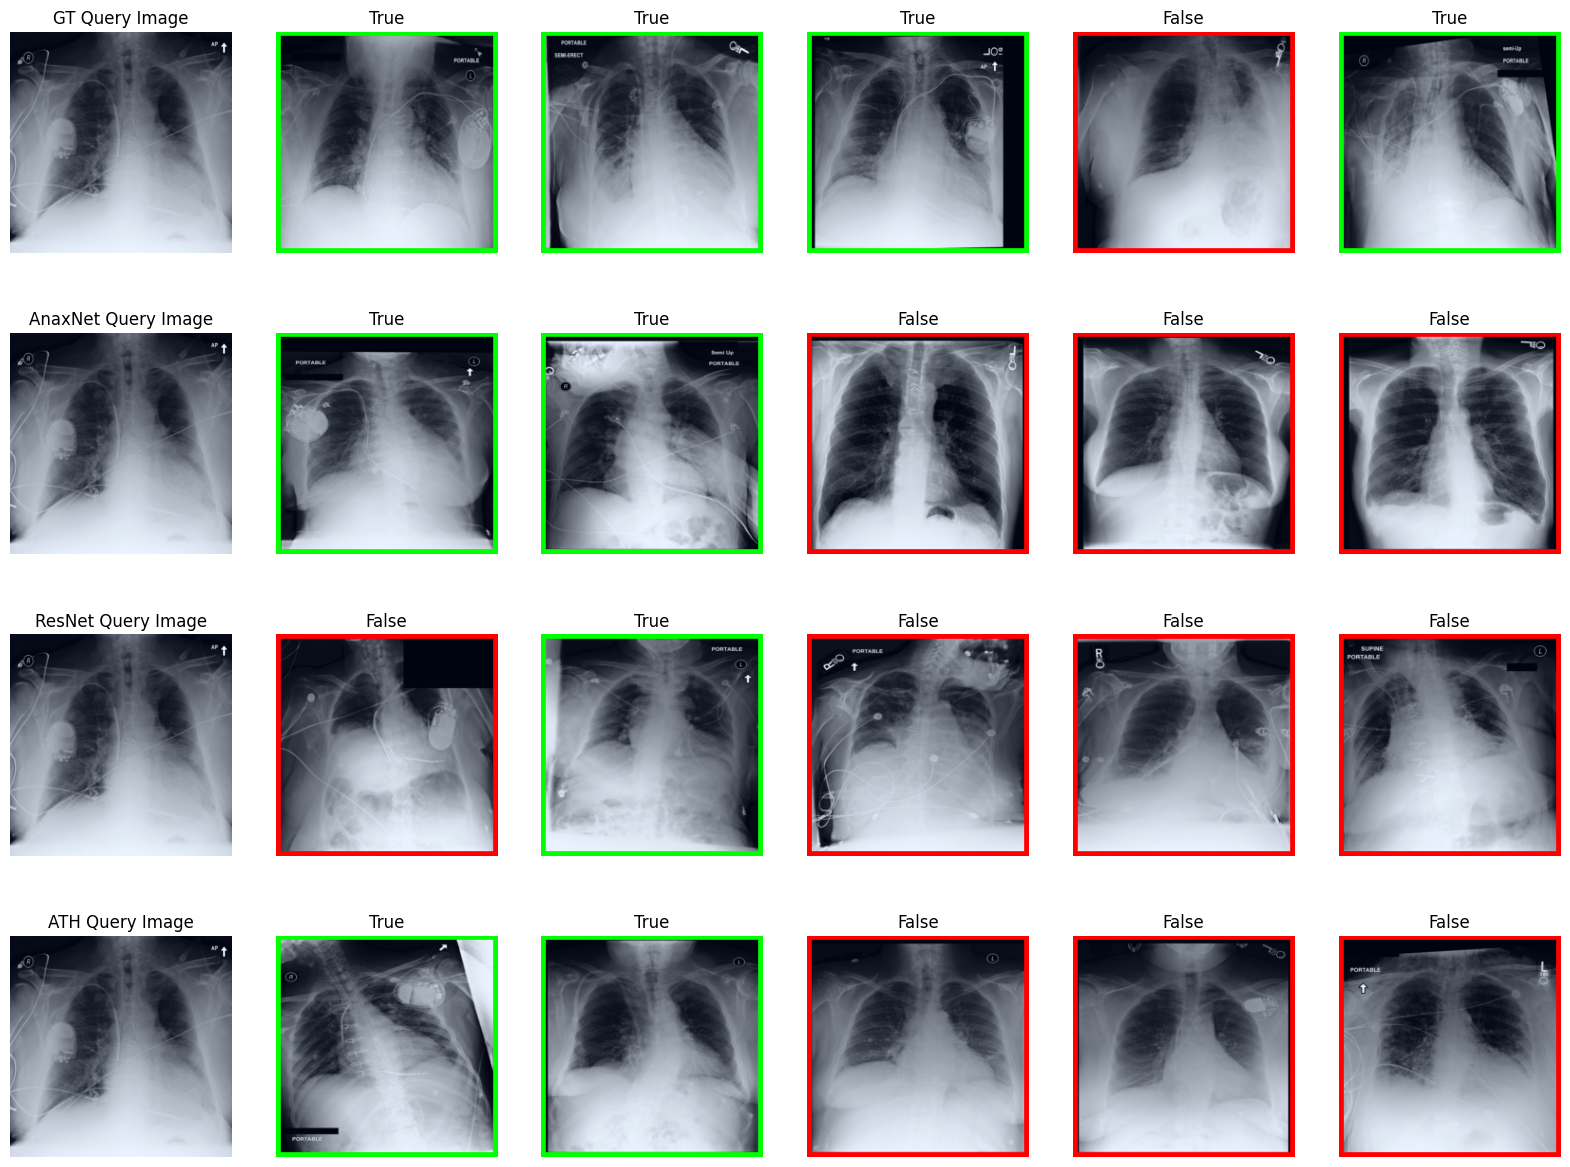

In [29]:
# for the given query index and corresponding retrieved indices, get the images
query_img = test_dataset[query_id]['global_feat']
retrieved_imgs = [test_dataset[idx]['global_feat'] for idx in retrieved_ids]
retrieved_imgs_anaxnet = [test_dataset[idx]['global_feat'] for idx in retrieved_ids_anaxnet]
retrieved_imgs_resnet = [test_dataset[idx]['global_feat'] for idx in retrieved_ids_resnet]
retrieved_imgs_ath = [test_dataset[idx]['global_feat'] for idx in retrieved_ids_ath]

# plot a 4 x 6 grid of images using for loop
plt.figure(figsize=(20, 15))

for i, img in enumerate([query_img, *retrieved_imgs]):
    plt.subplot(4, 6, i+1)
    plt.title(f'GT Query Image' if i == 0 else f'{retrieved_hits[i-1]}')
    plt.axis('off')
    plt.imshow(add_border(denormalize_image(img), color='green' if retrieved_hits[i-1] else 'red') if i != 0 else denormalize_image(img))

for i, img in enumerate([query_img, *retrieved_imgs_anaxnet]):
    plt.subplot(4, 6, i+7)
    plt.title(f'AnaxNet Query Image' if i == 0 else f'{retrieved_hits_anaxnet[i-1]}')
    plt.axis('off')
    plt.imshow(add_border(denormalize_image(img), color='green' if retrieved_hits_anaxnet[i-1] else 'red') if i != 0 else denormalize_image(img))

for i, img in enumerate([query_img, *retrieved_imgs_resnet]):
    plt.subplot(4, 6, i+13)
    plt.title(f'ResNet Query Image' if i == 0 else f'{retrieved_hits_resnet[i-1]}')
    plt.axis('off')
    plt.imshow(add_border(denormalize_image(img), color='green' if retrieved_hits_resnet[i-1] else 'red') if i != 0 else denormalize_image(img))

for i, img in enumerate([query_img, *retrieved_imgs_ath]):
    plt.subplot(4, 6, i+19)
    plt.title(f'ATH Query Image' if i == 0 else f'{retrieved_hits_ath[i-1]}')
    plt.axis('off')
    plt.imshow(add_border(denormalize_image(img), color='green' if retrieved_hits_ath[i-1] else 'red') if i != 0 else denormalize_image(img))

In [30]:
for r_id, lookup_dict in enumerate(tqdm(lookup_dicts)):
    for anatomy in anatomy_names:
        _, auc = deletion_for_anatomy(lookup_dict, best_model, anatomy)
        lookup_dicts[r_id][anatomy]['auc'] = auc

for r_id, lookup_dict in enumerate(tqdm(lookup_dicts_anaxnet)):
    for anatomy in anatomy_names:
        _, auc = deletion_for_anatomy(lookup_dict, anaxnet_model, anatomy)
        lookup_dicts_anaxnet[r_id][anatomy]['auc'] = auc

for r_id, lookup_dict in enumerate(tqdm(lookup_dicts_resnet)):
    for anatomy in anatomy_names:
        _, auc = deletion_for_anatomy(lookup_dict, resnet_model, anatomy, not_graph=True)
        lookup_dicts_resnet[r_id][anatomy]['auc'] = auc

for r_id, lookup_dict in enumerate(tqdm(lookup_dicts_ath)):
    for anatomy in anatomy_names:
        _, auc = deletion_for_anatomy(lookup_dict, ath_model, anatomy, not_graph=True, transforms=ath_transform)
        lookup_dicts_ath[r_id][anatomy]['auc'] = auc

100%|██████████| 5/5 [00:00<00:00,  6.76it/s]


In [31]:
consider_anatomies = [anatomy for anatomy in anatomy_names if anatomy not in ['right lung', 'left lung', 'mediastinum', 'upper mediastinum', 'trachea']]

heatmaps = []
for r_id, lookup_dict in enumerate(tqdm(lookup_dicts)):
    _, heatmap = deletion_for_all_anatomies(lookup_dict, best_model, anatomy_names=consider_anatomies)
    heatmaps.append(heatmap)

heatmaps_anaxnet = []
for r_id, lookup_dict in enumerate(tqdm(lookup_dicts_anaxnet)):
    _, heatmap = deletion_for_all_anatomies(lookup_dict, anaxnet_model, anatomy_names=consider_anatomies)
    heatmaps_anaxnet.append(heatmap)

heatmaps_resnet = []
for r_id, lookup_dict in enumerate(tqdm(lookup_dicts_resnet)):
    _, heatmap = deletion_for_all_anatomies(lookup_dict, resnet_model, anatomy_names=consider_anatomies, not_graph=True)
    heatmaps_resnet.append(heatmap)

heatmaps_ath = []
for r_id, lookup_dict in enumerate(tqdm(lookup_dicts_ath)):
    _, heatmap = deletion_for_all_anatomies(lookup_dict, ath_model, anatomy_names=consider_anatomies, not_graph=True, transforms=ath_transform)
    heatmaps_ath.append(heatmap)

100%|██████████| 5/5 [00:00<00:00, 14.64it/s]


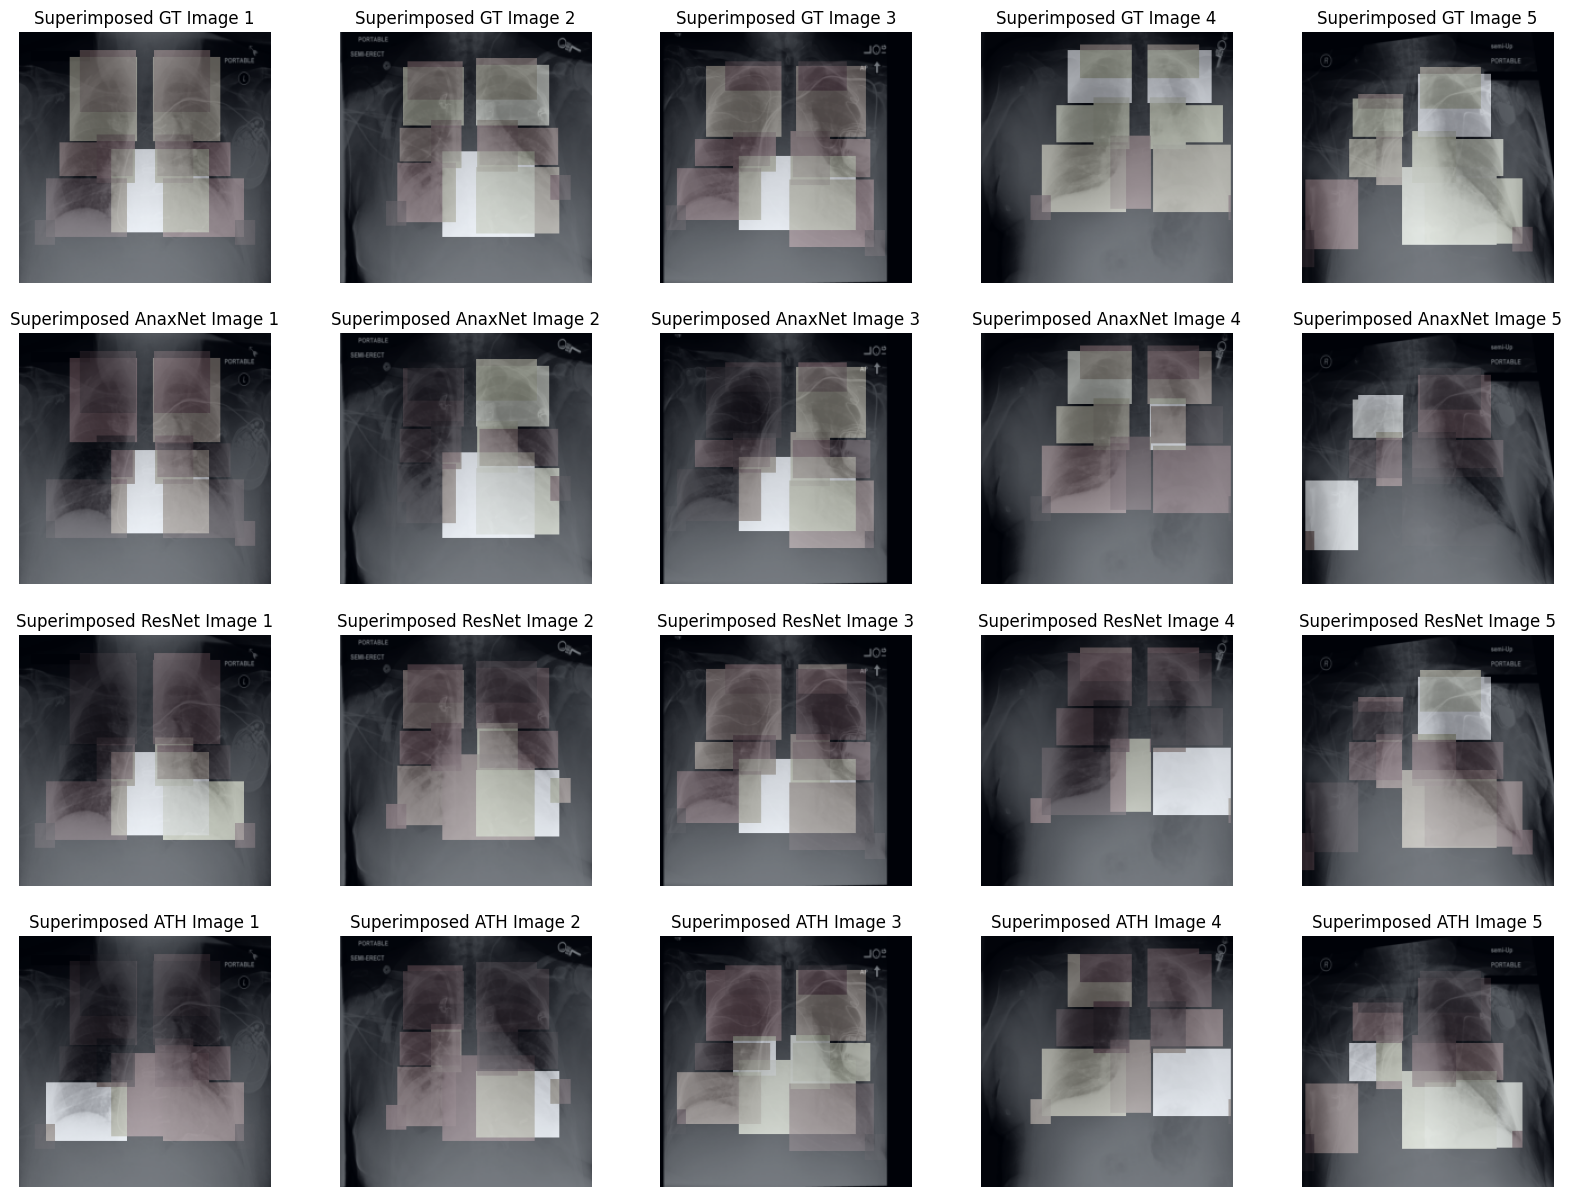

In [32]:
plt.figure(figsize=(20, 15))

for r_id, (heatmap, lookup_dict) in enumerate(zip(heatmaps, lookup_dicts)):
    plt.subplot(4, 5, r_id+1)
    plt.title(f'Superimposed GT Image {r_id+1}')
    plt.axis('off')
    plt.imshow(cv2.applyColorMap(denormalize_image(heatmap), cv2.COLORMAP_BONE)//2 + denormalize_image(lookup_dict['original']['img'])//2)

for r_id, (heatmap, lookup_dict) in enumerate(zip(heatmaps_anaxnet, lookup_dicts_anaxnet)):
    plt.subplot(4, 5, r_id+6)
    plt.title(f'Superimposed AnaxNet Image {r_id+1}')
    plt.axis('off')
    plt.imshow(cv2.applyColorMap(denormalize_image(heatmap), cv2.COLORMAP_BONE)//2 + denormalize_image(lookup_dict['original']['img'])//2)

for r_id, (heatmap, lookup_dict) in enumerate(zip(heatmaps_resnet, lookup_dicts_resnet)):
    plt.subplot(4, 5, r_id+11)
    plt.title(f'Superimposed ResNet Image {r_id+1}')
    plt.axis('off')
    plt.imshow(cv2.applyColorMap(denormalize_image(heatmap), cv2.COLORMAP_BONE)//2 + denormalize_image(lookup_dict['original']['img'])//2)

for r_id, (heatmap, lookup_dict) in enumerate(zip(heatmaps_ath, lookup_dicts_ath)):
    plt.subplot(4, 5, r_id+16)
    plt.title(f'Superimposed ATH Image {r_id+1}')
    plt.axis('off')
    plt.imshow(cv2.applyColorMap(denormalize_image(heatmap), cv2.COLORMAP_BONE)//2 + denormalize_image(lookup_dict['original']['img'])//2)


In [33]:
exp_images, exp_masks = [[] for _ in range(len(heatmaps))], [[] for _ in range(len(heatmaps))]
exp_images_anaxnet, exp_masks_anaxnet = [[] for _ in range(len(heatmaps_anaxnet))], [[] for _ in range(len(heatmaps_anaxnet))]
exp_images_resnet, exp_masks_resnet = [[] for _ in range(len(heatmaps_resnet))], [[] for _ in range(len(heatmaps_resnet))]
exp_images_ath, exp_masks_ath = [[] for _ in range(len(heatmaps_ath))], [[] for _ in range(len(heatmaps_ath))]

# torch.save({'query': query_img, 'retrieved': retrieved_imgs, 'heatmaps': heatmaps, 'exp_images': exp_images, 'exp_masks': exp_masks}, f'results/occlusion_analysis_sim_diff_{query_id}.pt')
# torch.save({'query': query_img, 'retrieved': retrieved_imgs_anaxnet, 'heatmaps': heatmaps_anaxnet, 'exp_images': exp_images_anaxnet, 'exp_masks': exp_masks_anaxnet}, f'results/occlusion_analysis_anaxnet_sim_diff_{query_id}.pt')
# torch.save({'query': query_img, 'retrieved': retrieved_imgs_resnet, 'heatmaps': heatmaps_resnet, 'exp_images': exp_images_resnet, 'exp_masks': exp_masks_resnet}, f'results/occlusion_analysis_resnet_sim_diff_{query_id}.pt')
# torch.save({'query': query_img, 'retrieved': retrieved_imgs_ath, 'heatmaps': heatmaps_ath, 'exp_images': exp_images_ath, 'exp_masks': exp_masks_ath}, f'results/occlusion_analysis_ath_sim_diff_{query_id}.pt')

In [34]:
def load_dict_from_file(file_name):
    saved_dict = torch.load(file_name)
    query_img = saved_dict['query']
    retrieved_imgs = saved_dict['retrieved']
    heatmaps = saved_dict['heatmaps']
    exp_images = saved_dict['exp_images']
    exp_masks = saved_dict['exp_masks']
    return query_img, retrieved_imgs, heatmaps, exp_images, exp_masks

In [ ]:
query_img, retrieved_imgs, heatmaps, exp_images, exp_masks = load_dict_from_file(f'results/occlusion_analysis_sim_diff_{query_id}.pt')
_, retrieved_imgs_anaxnet, heatmaps_anaxnet, exp_images_anaxnet, exp_masks_anaxnet = load_dict_from_file(f'results/occlusion_analysis_anaxnet_sim_diff_{query_id}.pt')
_, retrieved_imgs_resnet, heatmaps_resnet, exp_images_resnet, exp_masks_resnet = load_dict_from_file(f'results/occlusion_analysis_resnet_sim_diff_{query_id}.pt')
_, retrieved_imgs_ath, heatmaps_ath, exp_images_ath, exp_masks_ath = load_dict_from_file(f'results/occlusion_analysis_ath_sim_diff_{query_id}.pt')

In [35]:
query_index = consider_datapoint['query_indices'].values[0]

gt_retrieved_ids = eval(df_gt[(df_gt['query_indices'] == query_index)]['target_indices'].to_list()[0])
gt_retrieved_hits = eval(df_gt[(df_gt['query_indices'] == query_index)]['target_hit'].to_list()[0])

anaxnet_retrieved_ids = eval(df_anaxnet[(df_anaxnet['query_indices'] == query_index)]['target_indices'].to_list()[0])
anaxnet_retrieved_hits = eval(df_anaxnet[(df_anaxnet['query_indices'] == query_index)]['target_hit'].to_list()[0])

ath_retrieved_ids = eval(df_ath[(df_ath['query_indices'] == query_index)]['target_indices'].to_list()[0])
ath_retrieved_hits = eval(df_ath[(df_ath['query_indices'] == query_index)]['target_hit'].to_list()[0])

resnet_retrieved_ids = eval(df_resnet[(df_resnet['query_indices'] == query_index)]['target_indices'].to_list()[0])
resnet_retrieved_hits = eval(df_resnet[(df_resnet['query_indices'] == query_index)]['target_hit'].to_list()[0])

In [36]:
# for the given query index and corresponding retrieved indices, get the images
query_info = test_dataset[query_index]
gt_retrieved_info = [test_dataset[idx] for idx in gt_retrieved_ids]
anaxnet_retrieved_info = [test_dataset[idx] for idx in anaxnet_retrieved_ids]
ath_retrieved_info = [test_dataset[idx] for idx in ath_retrieved_ids]
resnet_retrieved_info = [test_dataset[idx] for idx in resnet_retrieved_ids]

In [37]:
query_img = query_info['global_feat']
gt_retrieved_imgs = [gt_info['global_feat'] for gt_info in gt_retrieved_info]
anaxnet_retrieved_imgs = [anaxnet_info['global_feat'] for anaxnet_info in anaxnet_retrieved_info]
ath_retrieved_imgs = [ath_info['global_feat'] for ath_info in ath_retrieved_info]
resnet_retrieved_imgs = [resnet_info['global_feat'] for resnet_info in resnet_retrieved_info]

In [ ]:
# plot a 4 x 6 grid of images using for loop
plt.figure(figsize=(20, 15))

for i, img in enumerate([query_img, *gt_retrieved_imgs]):
    plt.subplot(4, 6, i+1)
    plt.title(f'GT Query Image' if i == 0 else f'GT R{i}')
    plt.axis('off')
    plt.imshow(add_border(denormalize_image(img), color='green' if gt_retrieved_hits[i-1] else 'red') if i != 0 else denormalize_image(img))

for i, img in enumerate([query_img, *resnet_retrieved_imgs]):
    plt.subplot(4, 6, i+7)
    plt.title(f'ResNet50 Query Image' if i == 0 else f'ResNet50 R{i}')
    plt.axis('off')
    plt.imshow(add_border(denormalize_image(img), color='green' if resnet_retrieved_hits[i-1] else 'red') if i != 0 else denormalize_image(img))

for i, img in enumerate([query_img, *anaxnet_retrieved_imgs]):
    plt.subplot(4, 6, i+13)
    plt.title(f'Anaxnet Query Image' if i == 0 else f'Anaxnet R{i}')
    plt.axis('off')
    plt.imshow(add_border(denormalize_image(img), color='green' if anaxnet_retrieved_hits[i-1] else 'red') if i != 0 else denormalize_image(img))

for i, img in enumerate([query_img, *ath_retrieved_imgs]):
    plt.subplot(4, 6, i+19)
    plt.title(f'ATH Query Image' if i == 0 else f'ATH R{i}')
    plt.axis('off')
    plt.imshow(add_border(denormalize_image(img), color='green' if ath_retrieved_hits[i-1] else 'red') if i != 0 else denormalize_image(img))

In [ ]:
disease_dict = {disease: [anat] for (anat, lbl) in zip(anatomy_names, query_info['y']) for (disease, l) in zip(nine_class_labels, lbl) if l}

t = PrettyTable(['Disease', 'Anatomy'])
t.title = 'Query info'
for k, v in disease_dict.items():
    disease_dict[k] = list(set(v))
    if len(disease_dict[k]):
        t.add_row([k, ', '.join(disease_dict[k])])
print(t)

with open(f'final_figures/query_{query_index}.txt', 'w') as f:
    f.write(t.get_string())

In [ ]:
for r_id, retrieved_datapoint in enumerate(gt_retrieved_info):
    disease_dict = {disease: [anat] for (anat, lbl) in zip(anatomy_names, retrieved_datapoint['y']) for (disease, l) in zip(nine_class_labels, lbl) if l}

    print()
    t = PrettyTable(['Disease', 'Anatomy'])
    t.title = f'GT Retrieved-{r_id+1} info'
    for k, v in disease_dict.items():
        disease_dict[k] = list(set(v))
        if len(disease_dict[k]):
            t.add_row([k, ', '.join(disease_dict[k])])
    print(t)

    with open(f'final_figures/info_gt_{query_index}_{r_id}.txt', 'w') as f:
        f.write(t.get_string())

In [ ]:
for r_id, retrieved_datapoint in enumerate(resnet_retrieved_info):
    disease_dict = {disease: [anat] for (anat, lbl) in zip(anatomy_names, retrieved_datapoint['y']) for (disease, l) in zip(nine_class_labels, lbl) if l}

    print()
    t = PrettyTable(['Disease', 'Anatomy'])
    t.title = f'ResNet Retrieved-{r_id+1} info'
    for k, v in disease_dict.items():
        disease_dict[k] = list(set(v))
        if len(disease_dict[k]):
            t.add_row([k, ', '.join(disease_dict[k])])
    print(t)

    with open(f'final_figures/info_resnet_{query_index}_{r_id}.txt', 'w') as f:
        f.write(t.get_string())

In [ ]:
for r_id, retrieved_datapoint in enumerate(anaxnet_retrieved_info):
    disease_dict = {disease: [anat] for (anat, lbl) in zip(anatomy_names, retrieved_datapoint['y']) for (disease, l) in zip(nine_class_labels, lbl) if l}

    print()
    t = PrettyTable(['Disease', 'Anatomy'])
    t.title = f'Anaxnet Retrieved-{r_id+1} info'
    for k, v in disease_dict.items():
        disease_dict[k] = list(set(v))
        if len(disease_dict[k]):
            t.add_row([k, ', '.join(disease_dict[k])])
    print(t)

    with open(f'final_figures/info_anaxnet_{query_index}_{r_id}.txt', 'w') as f:
        f.write(t.get_string())

In [ ]:
for r_id, retrieved_datapoint in enumerate(ath_retrieved_info):
    disease_dict = {disease: [anat] for (anat, lbl) in zip(anatomy_names, retrieved_datapoint['y']) for (disease, l) in zip(nine_class_labels, lbl) if l}

    print()
    t = PrettyTable(['Disease', 'Anatomy'])
    t.title = f'ATH Retrieved-{r_id+1} info'
    for k, v in disease_dict.items():
        disease_dict[k] = list(set(v))
        if len(disease_dict[k]):
            t.add_row([k, ', '.join(disease_dict[k])])
    print(t)

    with open(f'final_figures/info_ath_{query_index}_{r_id}.txt', 'w') as f:
        f.write(t.get_string())

In [38]:
def load_dict_from_file(file_name):
    saved_dict = torch.load(file_name)
    query_img = saved_dict['query']
    retrieved_imgs = saved_dict['retrieved']
    heatmaps = saved_dict['heatmaps']
    exp_images = saved_dict['exp_images']
    exp_masks = saved_dict['exp_masks']
    return query_img, retrieved_imgs, heatmaps, exp_images, exp_masks

In [39]:
def smoothen(img, factor=8):
    dim = img.shape[0]
    # downsample and upsample the image
    img = cv2.resize(img, (dim//factor, dim//factor), interpolation=cv2.INTER_CUBIC)
    img = cv2.resize(img, (dim, dim), interpolation=cv2.INTER_CUBIC)

    return img

def get_heat_map_superimposed(exp_img, heatmap, retrieved_img):
    a = smoothen(denormalize_image(heatmap), factor=28)
    b = denormalize_image(retrieved_img)
    c = 3*((cv2.applyColorMap(255-a, cv2.COLORMAP_JET))//10) + 7*(b//10)
    return c

In [40]:
# query_id = 30
# query_id = 1811
query_img, retrieved_imgs, heatmaps, exp_images, exp_masks = load_dict_from_file(f'results/occlusion_analysis_sim_diff_{query_id}.pt')
_, retrieved_imgs_anaxnet, heatmaps_anaxnet, exp_images_anaxnet, exp_masks_anaxnet = load_dict_from_file(f'results/occlusion_analysis_anaxnet_sim_diff_{query_id}.pt')
_, retrieved_imgs_resnet, heatmaps_resnet, exp_images_resnet, exp_masks_resnet = load_dict_from_file(f'results/occlusion_analysis_resnet_sim_diff_{query_id}.pt')
_, retrieved_imgs_ath, heatmaps_ath, exp_images_ath, exp_masks_ath = load_dict_from_file(f'results/occlusion_analysis_ath_sim_diff_{query_id}.pt')

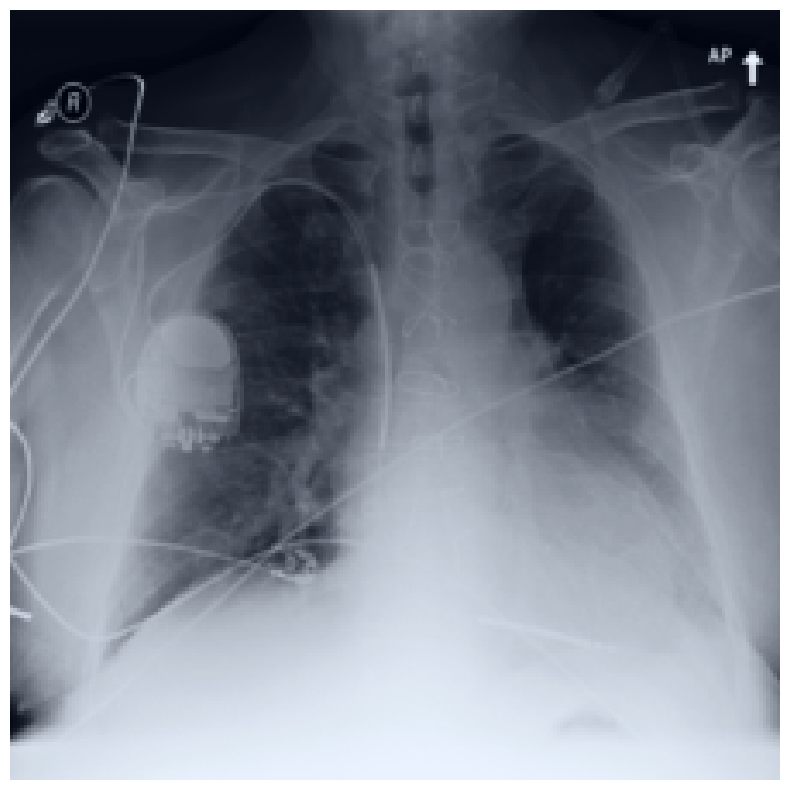

In [41]:
plt.close()
plt.figure(figsize=(10, 10))
plt.imshow(denormalize_image(query_img))
plt.axis('off')
plt.savefig(f'final_figures/query_{query_id}.png')

In [ ]:
for r_id, (lookup_dict, exp_img, heatmap, ret_img) in enumerate(zip(lookup_dicts, exp_images, heatmaps, retrieved_imgs)):
    img = get_heat_map_superimposed(exp_img, heatmap, ret_img)
    plt.close()
    plt.figure(figsize=(10, 10))
    plt.imshow(img)
    plt.axis('off')
    plt.savefig(f'final_figures/sim_diff_gt_{query_id}_{r_id}.png')

    temp_list = []
    for _, anatomy in enumerate(anatomy_names):
        mask = (lookup_dict[anatomy]['mask'] == 0)
        img = mask*heatmap
        temp_list.append(((img.sum()/mask.sum()).item(), anatomy))
    t = PrettyTable(['AUC', 'Anatomy'])
    for i, (val, anat) in enumerate(sorted(temp_list, key=lambda x: x[0], reverse=True)):
        t.add_row([np.round(val, 4), anat])
    with open(f'final_figures/sim_diff_gt_{query_id}_{r_id}.txt', 'w') as f:
        f.write(t.get_string())

for r_id, (lookup_dict, exp_img, heatmap, ret_img) in enumerate(zip(lookup_dicts_anaxnet, exp_images_anaxnet, heatmaps_anaxnet, retrieved_imgs_anaxnet)):
    img = get_heat_map_superimposed(exp_img, heatmap, ret_img)
    plt.close()
    plt.figure(figsize=(10, 10))
    plt.imshow(img)
    plt.axis('off')
    plt.savefig(f'final_figures/sim_diff_anaxnet_{query_id}_{r_id}.png')

    temp_list = []
    for _, anatomy in enumerate(anatomy_names):
        mask = (lookup_dict[anatomy]['mask'] == 0)
        img = mask*heatmap
        temp_list.append(((img.sum()/mask.sum()).item(), anatomy))
    t = PrettyTable(['AUC', 'Anatomy'])
    for i, (val, anat) in enumerate(sorted(temp_list, key=lambda x: x[0], reverse=True)):
        t.add_row([np.round(val, 4), anat])
    with open(f'final_figures/sim_diff_anaxnet_{query_id}_{r_id}.txt', 'w') as f:
        f.write(t.get_string())

for r_id, (lookup_dict, exp_img, heatmap, ret_img) in enumerate(zip(lookup_dicts_resnet, exp_images_resnet, heatmaps_resnet, retrieved_imgs_resnet)):
    img = get_heat_map_superimposed(exp_img, heatmap, ret_img)
    plt.close()
    plt.figure(figsize=(10, 10))
    plt.imshow(img)
    plt.axis('off')
    plt.savefig(f'final_figures/sim_diff_resnet_{query_id}_{r_id}.png')

    temp_list = []
    for _, anatomy in enumerate(anatomy_names):
        mask = (lookup_dict[anatomy]['mask'] == 0)
        img = mask*heatmap
        temp_list.append(((img.sum()/mask.sum()).item(), anatomy))
    t = PrettyTable(['AUC', 'Anatomy'])
    for i, (val, anat) in enumerate(sorted(temp_list, key=lambda x: x[0], reverse=True)):
        t.add_row([np.round(val, 4), anat])
    with open(f'final_figures/sim_diff_resnet_{query_id}_{r_id}.txt', 'w') as f:
        f.write(t.get_string())

for r_id, (lookup_dict, exp_img, heatmap, ret_img) in enumerate(zip(lookup_dicts_ath, exp_images_ath, heatmaps_ath, retrieved_imgs_ath)):
    img = get_heat_map_superimposed(exp_img, heatmap, ret_img)
    plt.close()
    plt.figure(figsize=(10, 10))
    plt.imshow(img)
    plt.axis('off')
    plt.savefig(f'final_figures/sim_diff_ath_{query_id}_{r_id}.png')

    temp_list = []
    for _, anatomy in enumerate(anatomy_names):
        mask = (lookup_dict[anatomy]['mask'] == 0)
        img = mask*heatmap
        temp_list.append(((img.sum()/mask.sum()).item(), anatomy))
    t = PrettyTable(['AUC', 'Anatomy'])
    for i, (val, anat) in enumerate(sorted(temp_list, key=lambda x: x[0], reverse=True)):
        t.add_row([np.round(val, 4), anat])
    with open(f'final_figures/sim_diff_ath_{query_id}_{r_id}.txt', 'w') as f:
        f.write(t.get_string())

In [55]:
relevant_anatomies = {anatomy: [] for anatomy in anatomy_names}
for i, anatomy in enumerate(anatomy_names):
    lbl = query_info['y'][i]
    relevant_anatomies[anatomy] = [nine_class_labels[i] for i, l in enumerate(lbl) if l]
relevant_anatomies = {k: ', '.join(v) for k, v in relevant_anatomies.items() if len(v) > 0}

t = PrettyTable(['Anatomy', 'Disease'])
t.title = 'Query info'
for k, v in relevant_anatomies.items():
    t.add_row([k, v])
print(t)

os.makedirs(f'final_figures/{query_id}/description', exist_ok=True)
with open(f'final_figures/{query_id}/description/info_query_{query_index}.txt', 'w') as f:
    f.write(t.get_string())
    f.write('\n')

+--------------------------------------------------+
|                    Query info                    |
+--------------------+-----------------------------+
|      Anatomy       |           Disease           |
+--------------------+-----------------------------+
| cardiac silhouette | enlarged cardiac silhouette |
+--------------------+-----------------------------+


{'right lung': 'lung opacity', 'right upper lung zone': 'lung opacity', 'right hilar structures': 'lung opacity', 'left lung': 'lung opacity', 'left upper lung zone': 'lung opacity', 'left hilar structures': 'lung opacity', 'cardiac silhouette': 'enlarged cardiac silhouette'}
{'right lung': 'lung opacity, pleural effusion, atelectasis, pulmonary edema/hazy opacity', 'right lower lung zone': 'lung opacity, pleural effusion, atelectasis', 'right hilar structures': 'lung opacity, pulmonary edema/hazy opacity', 'right costophrenic angle': 'lung opacity, pleural effusion', 'left lung': 'lung opacity, pleural effusion, atelectasis, pulmonary edema/hazy opacity', 'left lower lung zone': 'lung opacity, pleural effusion, atelectasis', 'left hilar structures': 'lung opacity, pulmonary edema/hazy opacity', 'left costophrenic angle': 'lung opacity, pleural effusion', 'cardiac silhouette': 'enlarged cardiac silhouette'}
{'right lung': 'lung opacity', 'left lung': 'lung opacity', 'cardiac silhouette

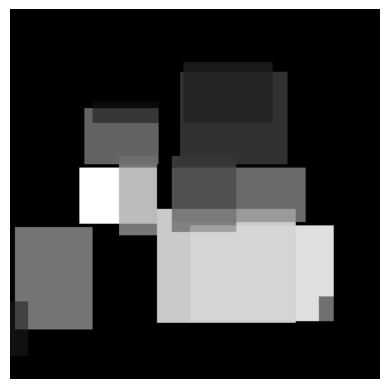

In [62]:
for r_id, (lookup_dict, exp_img, heatmap, ret_img) in enumerate(zip(lookup_dicts, exp_images, heatmaps, retrieved_imgs)):
    
    img = get_heat_map_superimposed(exp_img, heatmap, ret_img)
    relevant_anatomies = {anatomy: [] for anatomy in anatomy_names}

    edges = []
    for i, anatomy in enumerate(anatomy_names):
        lbl = gt_retrieved_info[r_id]['y'][i]
        if torch.sum(lbl) > 0:
            # run edge detection on mask
            mask = (lookup_dict[anatomy]['mask'] == 0)
            edge = cv2.Canny(denormalize_image(mask.float()), 100, 200)
            edges.append(edge)
            relevant_anatomies[anatomy] = [nine_class_labels[i] for i, l in enumerate(lbl) if l]
    relevant_anatomies = {k: ', '.join(v) for k, v in relevant_anatomies.items() if len(v) > 0}
    print(relevant_anatomies)

    t = PrettyTable(['Anatomy', 'Disease'])
    t.title = f'GT Retrieved-{r_id+1} info'
    for k, v in relevant_anatomies.items():
        t.add_row([k, v])
        
    if len(edges) > 0:
        # combine all edges
        edges = np.stack(edges, axis=-1)
        edges = edges.sum(axis=-1)
        edges = (edges > 0).astype(np.uint8)
        edges = cv2.dilate(edges, np.ones((2, 2), np.uint8), iterations=1)
        
        # superimpose edges on the original image
        img[edges == 1] = 0
    
    plt.imshow(img)
    plt.axis('off')
    
    os.makedirs(f'final_figures/{query_id}/bounding_boxes', exist_ok=True)
    plt.savefig(f'final_figures/{query_id}/bounding_boxes/img_gt_{query_id}_{r_id+1}_edges.png')

    plt.close()
    plt.imshow(denormalize_image(ret_img))
    plt.axis('off')
    os.makedirs(f'final_figures/{query_id}/retrieved_imgs', exist_ok=True)
    plt.savefig(f'final_figures/{query_id}/retrieved_imgs/img_gt_{query_id}_{r_id+1}.png')

    plt.close()
    plt.imshow(denormalize_image(heatmap))
    plt.axis('off')
    os.makedirs(f'final_figures/{query_id}/heatmaps', exist_ok=True)
    plt.savefig(f'final_figures/{query_id}/heatmaps/img_gt_{query_id}_{r_id+1}.png')

    os.makedirs(f'final_figures/{query_id}/description', exist_ok=True)
    with open(f'final_figures/{query_id}/description/info_gt_{query_index}_{r_id+1}.txt', 'w') as f:
        f.write(t.get_string())
        f.write('\n')

for r_id, (lookup_dict, exp_img, heatmap, ret_img) in enumerate(zip(lookup_dicts_anaxnet, exp_images_anaxnet, heatmaps_anaxnet, retrieved_imgs_anaxnet)):
    img = get_heat_map_superimposed(exp_img, heatmap, ret_img)
    relevant_anatomies = {anatomy: [] for anatomy in anatomy_names}

    edges = []
    for i, anatomy in enumerate(anatomy_names):
        lbl = anaxnet_retrieved_info[r_id]['y'][i]
        if torch.sum(lbl) > 0:
            # run edge detection on mask
            mask = (lookup_dict[anatomy]['mask'] == 0)
            edge = cv2.Canny(denormalize_image(mask.float()), 100, 200)
            edges.append(edge)
            relevant_anatomies[anatomy] = [nine_class_labels[i] for i, l in enumerate(lbl) if l]
    relevant_anatomies = {k: ', '.join(v) for k, v in relevant_anatomies.items() if len(v) > 0}
    print(relevant_anatomies)

    t = PrettyTable(['Anatomy', 'Disease'])
    t.title = f'Anaxnet Retrieved-{r_id+1} info'
    for k, v in relevant_anatomies.items():
        t.add_row([k, v])
        
    if len(edges) > 0:
        # combine all edges
        edges = np.stack(edges, axis=-1)
        edges = edges.sum(axis=-1)
        edges = (edges > 0).astype(np.uint8)
        edges = cv2.dilate(edges, np.ones((2, 2), np.uint8), iterations=1)
        
        # superimpose edges on the original image
        img[edges == 1] = 0
    
    plt.imshow(img)
    plt.axis('off')
    
    os.makedirs(f'final_figures/{query_id}/bounding_boxes', exist_ok=True)
    plt.savefig(f'final_figures/{query_id}/bounding_boxes/img_anaxnet_{query_id}_{r_id+1}_edges.png')

    plt.close()
    plt.imshow(denormalize_image(ret_img))
    plt.axis('off')
    os.makedirs(f'final_figures/{query_id}/retrieved_imgs', exist_ok=True)
    plt.savefig(f'final_figures/{query_id}/retrieved_imgs/img_anaxnet_{query_id}_{r_id+1}.png')

    plt.close()
    plt.imshow(denormalize_image(heatmap))
    plt.axis('off')
    os.makedirs(f'final_figures/{query_id}/heatmaps', exist_ok=True)
    plt.savefig(f'final_figures/{query_id}/heatmaps/img_anaxnet_{query_id}_{r_id+1}.png')

    os.makedirs(f'final_figures/{query_id}/description', exist_ok=True)
    with open(f'final_figures/{query_id}/description/info_anaxnet_{query_index}_{r_id+1}.txt', 'w') as f:
        f.write(t.get_string())
        f.write('\n')

for r_id, (lookup_dict, exp_img, heatmap, ret_img) in enumerate(zip(lookup_dicts_resnet, exp_images_resnet, heatmaps_resnet, retrieved_imgs_resnet)):
    img = get_heat_map_superimposed(exp_img, heatmap, ret_img)
    relevant_anatomies = {anatomy: [] for anatomy in anatomy_names}

    edges = []
    for i, anatomy in enumerate(anatomy_names):
        lbl = resnet_retrieved_info[r_id]['y'][i]
        if torch.sum(lbl) > 0:
            # run edge detection on mask
            mask = (lookup_dict[anatomy]['mask'] == 0)
            edge = cv2.Canny(denormalize_image(mask.float()), 100, 200)
            edges.append(edge)
            relevant_anatomies[anatomy] = [nine_class_labels[i] for i, l in enumerate(lbl) if l]
    relevant_anatomies = {k: ', '.join(v) for k, v in relevant_anatomies.items() if len(v) > 0}
    print(relevant_anatomies)

    t = PrettyTable(['Anatomy', 'Disease'])
    t.title = f'ResNet Retrieved-{r_id+1} info'
    for k, v in relevant_anatomies.items():
        t.add_row([k, v])
        
    if len(edges) > 0:
        # combine all edges
        edges = np.stack(edges, axis=-1)
        edges = edges.sum(axis=-1)
        edges = (edges > 0).astype(np.uint8)
        edges = cv2.dilate(edges, np.ones((2, 2), np.uint8), iterations=1)
        
        # superimpose edges on the original image
        img[edges == 1] = 0
    
    plt.imshow(img)
    plt.axis('off')
    
    os.makedirs(f'final_figures/{query_id}/bounding_boxes', exist_ok=True)
    plt.savefig(f'final_figures/{query_id}/bounding_boxes/img_resnet_{query_id}_{r_id+1}_edges.png')

    plt.close()
    plt.imshow(denormalize_image(ret_img))
    plt.axis('off')
    os.makedirs(f'final_figures/{query_id}/retrieved_imgs', exist_ok=True)
    plt.savefig(f'final_figures/{query_id}/retrieved_imgs/img_resnet_{query_id}_{r_id+1}.png')

    plt.close()
    plt.imshow(denormalize_image(heatmap))
    plt.axis('off')
    os.makedirs(f'final_figures/{query_id}/heatmaps', exist_ok=True)
    plt.savefig(f'final_figures/{query_id}/heatmaps/img_resnet_{query_id}_{r_id+1}.png')

    os.makedirs(f'final_figures/{query_id}/description', exist_ok=True)
    with open(f'final_figures/{query_id}/description/info_resnet_{query_index}_{r_id+1}.txt', 'w') as f:
        f.write(t.get_string())
        f.write('\n')

for r_id, (lookup_dict, exp_img, heatmap, ret_img) in enumerate(zip(lookup_dicts_ath, exp_images_ath, heatmaps_ath, retrieved_imgs_ath)):  
    img = get_heat_map_superimposed(exp_img, heatmap, ret_img)
    relevant_anatomies = {anatomy: [] for anatomy in anatomy_names}

    edges = []
    for i, anatomy in enumerate(anatomy_names):
        lbl = ath_retrieved_info[r_id]['y'][i]
        if torch.sum(lbl) > 0:
            # run edge detection on mask
            mask = (lookup_dict[anatomy]['mask'] == 0)
            edge = cv2.Canny(denormalize_image(mask.float()), 100, 200)
            edges.append(edge)
            relevant_anatomies[anatomy] = [nine_class_labels[i] for i, l in enumerate(lbl) if l]
    relevant_anatomies = {k: ', '.join(v) for k, v in relevant_anatomies.items() if len(v) > 0}
    print(relevant_anatomies)

    t = PrettyTable(['Anatomy', 'Disease'])
    t.title = f'ATH Retrieved-{r_id+1} info'
    for k, v in relevant_anatomies.items():
        t.add_row([k, v])
        
    if len(edges) > 0:
        # combine all edges
        edges = np.stack(edges, axis=-1)
        edges = edges.sum(axis=-1)
        edges = (edges > 0).astype(np.uint8)
        edges = cv2.dilate(edges, np.ones((2, 2), np.uint8), iterations=1)
        
        # superimpose edges on the original image
        img[edges == 1] = 0
    
    plt.imshow(img)
    plt.axis('off')
    
    os.makedirs(f'final_figures/{query_id}/bounding_boxes', exist_ok=True)
    plt.savefig(f'final_figures/{query_id}/bounding_boxes/img_ath_{query_id}_{r_id+1}_edges.png')

    plt.close()
    plt.imshow(denormalize_image(ret_img))
    plt.axis('off')
    os.makedirs(f'final_figures/{query_id}/retrieved_imgs', exist_ok=True)
    plt.savefig(f'final_figures/{query_id}/retrieved_imgs/img_ath_{query_id}_{r_id+1}.png')

    plt.close()
    plt.imshow(denormalize_image(heatmap))
    plt.axis('off') 
    os.makedirs(f'final_figures/{query_id}/heatmaps', exist_ok=True)
    plt.savefig(f'final_figures/{query_id}/heatmaps/img_ath_{query_id}_{r_id+1}.png')

    os.makedirs(f'final_figures/{query_id}/description', exist_ok=True)
    with open(f'final_figures/{query_id}/description/info_ath_{query_index}_{r_id+1}.txt', 'w') as f:
        f.write(t.get_string())
        f.write('\n')